# Prior and Posterior Predictive Checks
事後予測チェック (PPC) は、モデルを検証する優れた方法です。 このアイデアは、事後からの描画からのパラメーターを使用してモデルからデータを生成することです。

少し詳しく説明すると、PPC はモデルから生成されたデータが真の分布から生成されたデータからどの程度逸脱しているかを分析すると言えます。 したがって、たとえば、事後分布が基礎となる分布に近似しているかどうかを知りたいことがよくあります。 このモデル評価方法の視覚化の側面は、「感覚チェック」や他の人にモデルを説明して批判を受けるのにも最適です。

事前の予測チェックもベイジアン モデリング ワークフローの重要な部分です。 基本的に、これらには 2 つの主な利点があります:

* これらを使用すると、実際に科学的知識をモデルに組み込んでいるかどうかを確認できます。つまり、データを確認する前に、自分の仮定がどの程度信頼できるかを確認するのに役立ちます。
* これらは、特にリンク関数により結果空間とパラメーター空間が発散する一般化線形モデルの場合、サンプリングに大幅に役立ちます。

ここでは、モデルの観察されたノードからサンプルを抽出するための一般的なルーチンを実装します。 モデルは基本的なものですが、独自のルーチンを作成するための足がかりになります。 より複雑な多次元モデルで事前および事後予測チェックを行う方法を知りたい場合は、[このノートブック](https://github.com/aloctavodia/BAP/blob/master/extras/multinomial_ppcs.ipynb) を確認してください。 では、試食してみましょう！

In [20]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import xarray as xr

from scipy.special import expit as logistic


print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.12.0


In [21]:
az.style.use("arviz-darkgrid")

RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

非常に単純な線形回帰モデルを生成してみましょう。 意図的に、標準の法線に由来しないデータをシミュレートします (理由は後で説明します):

In [22]:
N = 100

true_a, true_b, predictor = 0.5, 3.0, rng.normal(loc = 2, scale = 6, size = N)
true_mu = true_a + true_b * predictor
true_sd = 2.0

outcome = rng.normal(loc=true_mu, scale=true_sd, size=N)

f"{predictor.mean():.2f}, {predictor.std():.2f}, {outcome.mean():.2f}, {outcome.std():.2f}"

'1.59, 5.69, 4.97, 17.54'

ご覧のとおり、予測変数と結果のばらつきは非常に大きく、これは実際のデータではよくあることです。 そして、場合によっては、サンプラーがこれを気に入らないこともあります。そして、ベイジアンである場合、サンプラーを怒らせたくないでしょう…そこで、実際のデータに対して頻繁に行う必要があること、つまり標準化を行いましょう。 こうすることで、予測子と結果の平均は 0、標準偏差は 1 になり、サンプラーはより快適になります:

In [23]:
predictor_scaled = standardize(predictor)
outcome_scaled = standardize(outcome)

f"{predictor_scaled.mean():.2f}, {predictor_scaled.std():.2f}, {outcome_scaled.mean():.2f}, {outcome_scaled.std():.2f}"

'0.00, 1.00, -0.00, 1.00'

それでは、従来のフラット事前確率を使用してモデルを作成し、事前予測サンプルをサンプリングしてみましょう:

In [24]:
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 10.0)
    b = pm.Normal("b", 0.0, 10.0)

    mu = a + b * predictor_scaled
    sigma = pm.Exponential("sigma", 1.0)

    pm.Normal("obs", mu = mu, sigma = sigma, observed = outcome_scaled)
    idata = pm.sample_prior_predictive(samples = 50, random_seed = rng)

Sampling: [a, b, obs, sigma]


これらの事前確率は何を意味するのでしょうか? 紙の上で伝えるのは常に困難です。最善の方法は、結果のスケールにその影響をプロットすることです。次のようになります。:

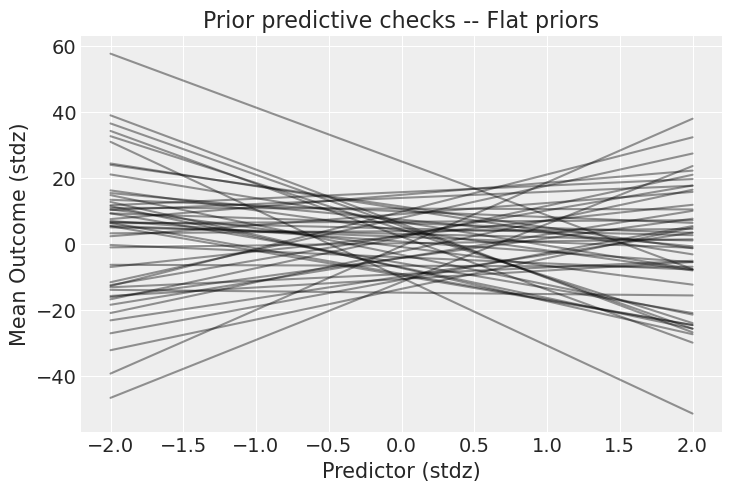

In [25]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-2, 2, 50), dims = ["plot_dim"])
prior = idata.prior
y = prior["a"] + prior["b"] * x

ax.plot(x, y.stack(sample = ("chain", "draw")), c = "k", alpha = 0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Flat priors");

これらの事前分布により、結果と予測変数の間に異常に強い関係が可能になります。 もちろん、事前の選択は常にモデルとデータに依存しますが、y 軸のスケールに注目してください。結果は -40 から +40 の標準偏差になる可能性があります (データは標準化されていることに注意してください)。 これはあまりにも寛容すぎることに同意していただけると思いますが? もっと良くできるよ！ [情報量の少ない事前分布](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations) を使用して、それが何をもたらすかを見てみましょう。 実際のケーススタディでは、これは科学的知識をモデルに組み込む部分です。

In [26]:
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 0.5)
    b = pm.Normal("b", 0.0, 1.0)

    mu = a + b * predictor_scaled
    sigma = pm.Exponential("sigma", 1.0)

    pm.Normal("obs", mu = mu, sigma = sigma, observed = outcome_scaled)
    idata = pm.sample_prior_predictive(samples = 50, random_seed = rng)

Sampling: [a, b, obs, sigma]


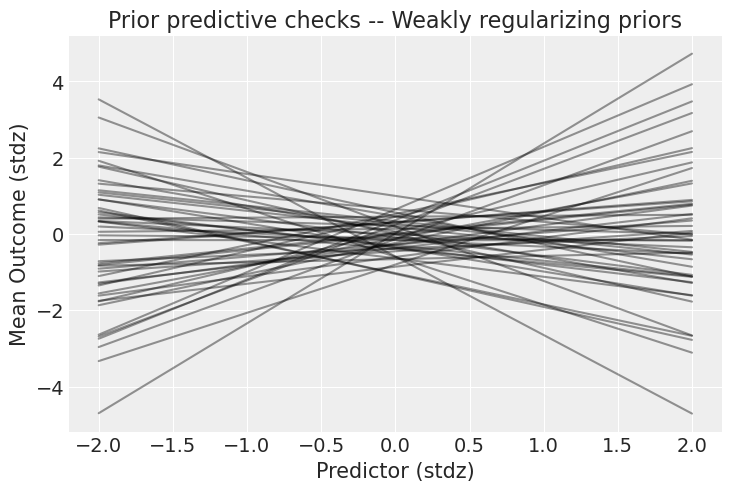

In [27]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-2, 2, 50), dims = ["plot_dim"])
prior = idata.prior
y = prior["a"] + prior["b"] * x

ax.plot(x, y.stack(sample = ("chain", "draw")), c = "k", alpha = 0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Weakly regularizing priors");

まあ、それはずっと良いことです！ 依然として非常に強い関係が続いていますが、少なくとも現時点では結果は可能性の領域にとどまっています。 さあ、パーティーの時間です。もちろん、「パーティー」という言葉が「モデルを実行する」ことを意味するのであれば。

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 25 seconds.


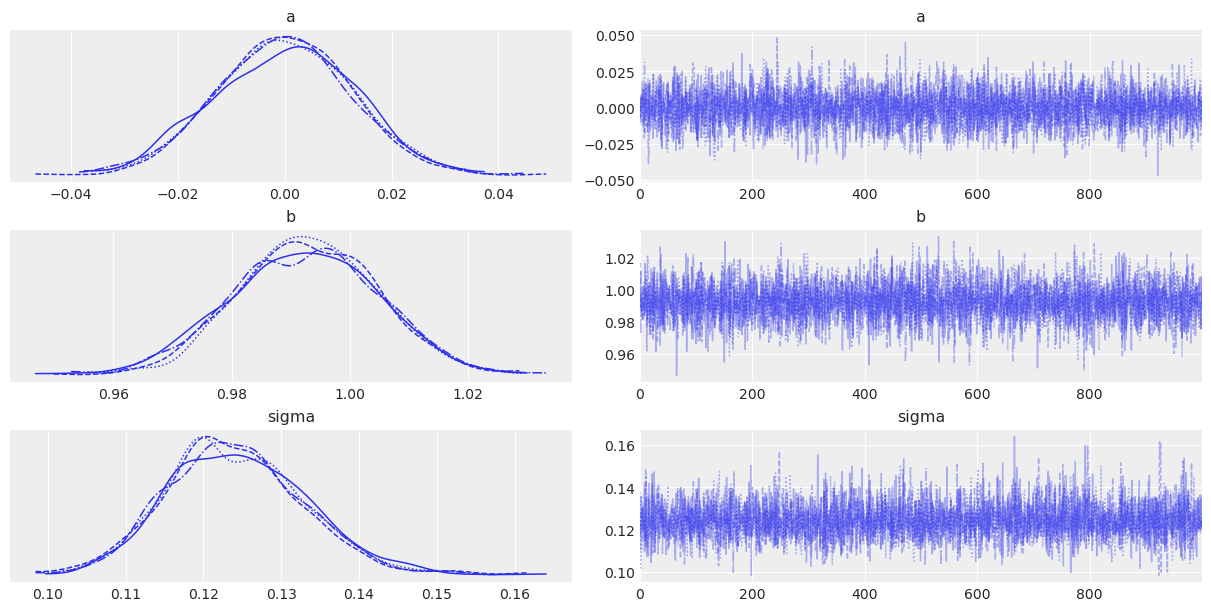

In [28]:
with model_1:
    idata.extend(pm.sample(1000, tune = 2000, random_seed = rng))

az.plot_trace(idata);

すべてがスムーズに実行されましたが、トレース プロットやテーブルの概要を分析するときにパラメーターの値が何を意味するのかを理解するのが難しいことがよくあります。 ここではパラメータが標準化された空間内に存在するため、さらにそうです。 モデルを理解するのに役立つのは…ご想像のとおり、事後予測チェックです。 PyMC の専用関数を使用して事後データをサンプリングします。 この関数は、トレースからパラメータの 4000 サンプルをランダムに抽出します。 次に、サンプルごとに、そのサンプルの ```mu``` と ```sigma``` の値で指定された正規分布から 100 個の乱数を抽出します。

In [29]:
with model_1:
    pm.sample_posterior_predictive(idata, extend_inferencedata = True, random_seed = rng)

Sampling: [obs]


さて、``idata`` の posterior_predictive グループには 4000 個の生成されたデータセット (それぞれ 100 個のサンプルを含む) が含まれており、それぞれが事後データセットとは異なるパラメーター設定を使用しています。

In [30]:
idata.posterior_predictive

<xarray.Dataset> Size: 3MB
Dimensions:    (chain: 4, draw: 1000, obs_dim_2: 100)
Coordinates:
  * chain      (chain) int32 16B 0 1 2 3
  * draw       (draw) int32 4kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * obs_dim_2  (obs_dim_2) int32 400B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
Data variables:
    obs        (chain, draw, obs_dim_2) float64 3MB -0.5997 0.312 ... 0.4695
Attributes:
    created_at:                 2024-04-03T05:22:11.053958
    arviz_version:              0.17.1
    inference_library:          pymc
    inference_library_version:  5.12.0

視覚化する一般的な方法の 1 つは、実際のデータで観察されたパターンをモデルが再現できるかどうかを確認することです。 [ArviZ](https://python.arviz.org/en/latest/index.html) には、それをすぐに実行できる非常に優れた機能があります

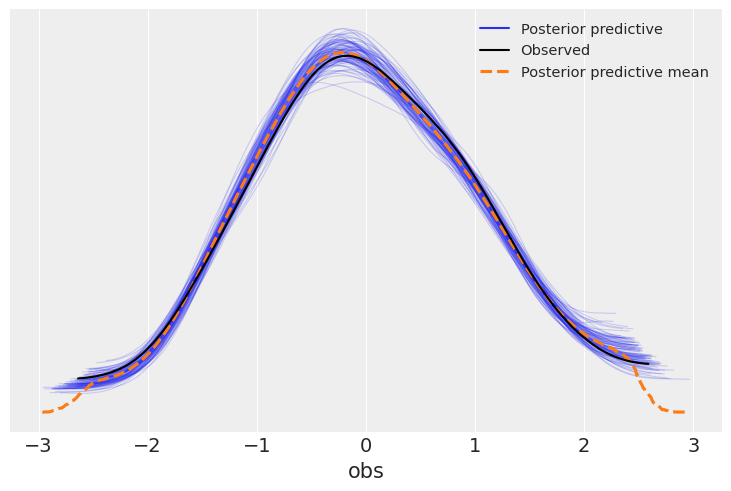

In [31]:
az.plot_ppc(idata, num_pp_samples = 100);

このモデルはデータを遡及するのに非常に優れているようです。 この一般的な関数に加えて、ユースケースに合わせてプロットを作成すると便利です。 ここで、予測子と結果の間の予測された関係をプロットすると興味深いでしょう。 すでに事後予測サンプルをサンプリングしたので、これは非常に簡単です。モデルにパラメータをプッシュするだけです:

In [32]:
post = idata.posterior
mu_pp = post["a"] + post["b"] * xr.DataArray(predictor_scaled, dims = ["obs_id"])

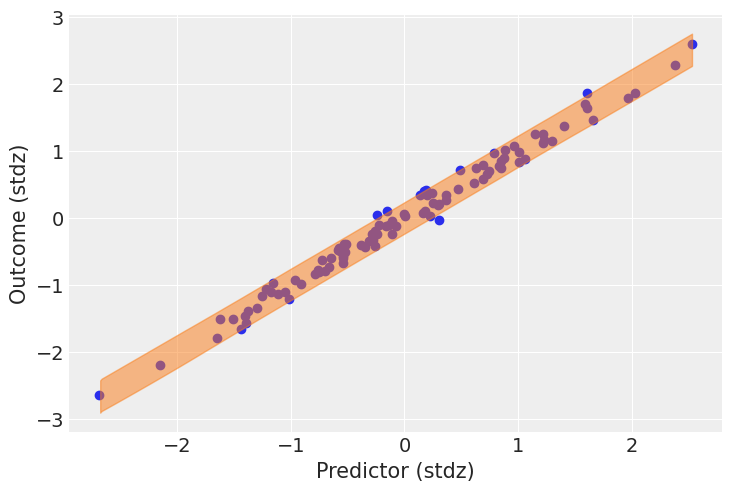

In [41]:
_, ax = plt.subplots()

ax.plot(
    predictor_scaled, mu_pp.mean(("chain", "draw")), label="Mean outcome", color = "C1", alpha = 0.6
)
ax.scatter(predictor_scaled, idata.observed_data["obs"])
az.plot_hdi(predictor_scaled, idata.posterior_predictive["obs"])

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Outcome (stdz)");

大量のデータがあるため、結果の平均値に関する不確実性はかなり狭いです。 しかし、一般に結果を取り巻く不確実性は、観察されたデータと完全に一致しているようです。

## Comparison between PPC and other model evaluation methods.
これについては、[Edward](https://edwardlib.org/) ドキュメントで優れた紹介が行われています。

> PPC は、モデルがデータにどの程度適合しているかを調べながら、モデルを修正したり、現在のモデルを単純化または拡張したりするための優れたツールです。 これらは、モデルは大規模なサンプル評価の頻度主義的な観点に基づいて批判されるべきであるという哲学の下で、事前のチェックと古典的な仮説検定に触発されています。

> PPC は、仮説検定、モデルの比較、モデルの選択、モデルの平均化などのタスクにも適用できます。 仮説テストはベイジアン仮説検定の形式として適用できますが、一般に推奨されないことに注意することが重要です。単一のテストからの二者択一の意思決定は、考えられているほど一般的なユースケースではありません。 モデルの適合性を全体的に理解するために、多くの PPC を実行することをお勧めします。

## Prediction
同じパターンを予測に使用できます。 ここではロジスティック回帰モデルを構築しています.

In [34]:
N = 400
true_intercept = 0.2
true_slope = 1.0
predictors = rng.normal(size = N)
true_p = logistic(true_intercept + true_slope * predictors)

outcomes = rng.binomial(1, true_p)
outcomes[:10]

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 0], dtype=int64)

In [35]:
with pm.Model() as model_2:
    betas = pm.Normal("betas", mu = 0.0, sigma = np.array([0.5, 1.0]), shape = 2)

    # set predictors as shared variable to change them for PPCs:
    pred = pm.MutableData("pred", predictors, dims = "obs_id")
    p = pm.Deterministic("p", pm.math.invlogit(betas[0] + betas[1] * pred), dims = "obs_id")

    outcome = pm.Bernoulli("outcome", p = p, observed = outcomes, dims = "obs_id")

    idata_2 = pm.sample(1000, tune = 2000, return_inferencedata = True, random_seed = rng)

az.summary(idata_2, var_names = ["betas"], round_to = 2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 25 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.23,0.11,0.03,0.44,0.0,0.0,3211.49,3013.30,1.0
betas[1],1.03,0.13,0.78,1.29,0.0,0.0,3673.85,2720.49,1.0


次に、サンプル外データをシミュレートして、モデルがそれらをどのように予測するかを確認しましょう。 新しい予測子をモデルに与えると、モデルはトレーニング ラウンドで学習した内容に基づいて、結果がどのようなものであると考えるかを教えてくれます。 次に、モデルの予測をサンプル外の実際の結果と比較します。

In [36]:
predictors_out_of_sample = rng.normal(size = 50)
outcomes_out_of_sample = rng.binomial(
    1, logistic(true_intercept + true_slope * predictors_out_of_sample)
)

with model_2:
    # update values of predictors:
    pm.set_data({"pred": predictors_out_of_sample})
    # use the updated values and predict outcomes and probabilities:
    idata_2 = pm.sample_posterior_predictive(
        idata_2,
        var_names = ["p"],
        return_inferencedata = True,
        predictions = True,
        extend_inferencedata = True,
        random_seed = rng,
    )

Sampling: []


### Mean predicted values plus error bars to give a sense of uncertainty in prediction
完全事後を扱っているため、無料で予測の不確実性も得られることに注意してください。

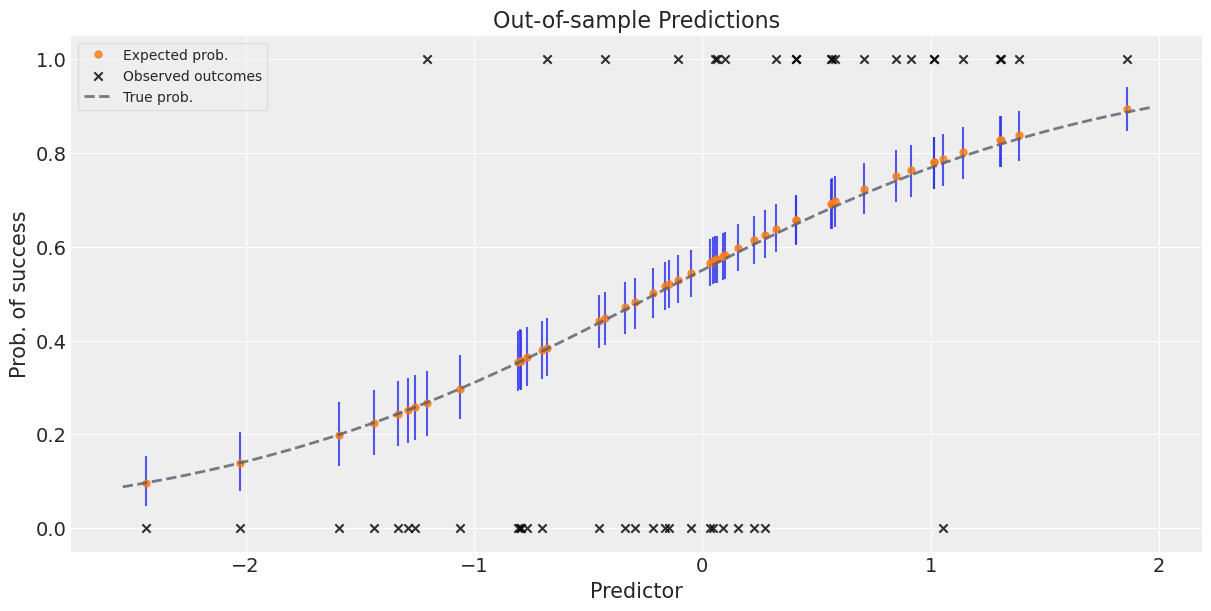

In [37]:
_, ax = plt.subplots(figsize = (12, 6))

preds_out_of_sample = idata_2.predictions_constant_data.sortby("pred")["pred"]
model_preds = idata_2.predictions.sortby(preds_out_of_sample)

# uncertainty about the estimates:
ax.vlines(
    preds_out_of_sample,
    *az.hdi(model_preds)["p"].transpose("hdi", ...),
    alpha=0.8,
)
# expected probability of success:
ax.plot(
    preds_out_of_sample,
    model_preds["p"].mean(("chain", "draw")),
    "o",
    ms = 5,
    color = "C1",
    alpha = 0.8,
    label = "Expected prob.",
)

# actual outcomes:
ax.scatter(
    x = predictors_out_of_sample,
    y = outcomes_out_of_sample,
    marker = "x",
    color = "k",
    alpha = 0.8,
    label = "Observed outcomes",
)
# true probabilities:
x = np.linspace(predictors_out_of_sample.min() - 0.1, predictors_out_of_sample.max() + 0.1)
ax.plot(
    x,
    logistic(true_intercept + true_slope * x),
    lw = 2,
    ls = "--",
    color = "#565C6C",
    alpha = 0.8,
    label = "True prob.",
)

ax.set_xlabel("Predictor")
ax.set_ylabel("Prob. of success")
ax.set_title("Out-of-sample Predictions")
ax.legend(fontsize = 10, frameon = True, framealpha = 0.5);

In [38]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Wed Apr 03 2024

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

pytensor: 2.19.0

arviz     : 0.17.1
matplotlib: 3.8.3
numpy     : 1.26.4
xarray    : 2024.3.0
pymc      : 5.12.0

Watermark: 2.4.3

